In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [293]:
# Load the dataset
df = pd.read_csv('../data/raw/training_data.csv')

# Display initial information
print("Initial Data Info:")
df.info()

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               14304 non-null  int64 
 1   title                14304 non-null  object
 2   location             14024 non-null  object
 3   department           5029 non-null   object
 4   salary_range         2283 non-null   object
 5   company_profile      11632 non-null  object
 6   description          14303 non-null  object
 7   requirements         12172 non-null  object
 8   benefits             8501 non-null   object
 9   telecommuting        14304 non-null  int64 
 10  has_company_logo     14304 non-null  int64 
 11  has_questions        14304 non-null  int64 
 12  employment_type      11547 non-null  object
 13  required_experience  8629 non-null   object
 14  required_education   7805 non-null   object
 15  industry             10378 non-nul

In [294]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,7531,Contact Center Representatives,"US, VA, Virginia Beach",NaN,NaN,Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",The position requires the following qualificat...,Our company offers a competitive salary plus B...,0,1,0,Full-time,Entry level,Unspecified,Financial Services,Customer Service,0
1,130,Customer Service Associate,"US, TX, Dallas",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,QualificationsMinimum of 1 year customer servi...,NaN,0,1,0,Full-time,Entry level,High School or equivalent,Telecommunications,Customer Service,0
2,4641,Automated Test Analyst,"NZ, , Auckland",Permanent,NaN,SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,NaN,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Information Technology and Services,NaN,0
3,403,Inside Sales Professional-Omaha,"US, NE, Omaha",NaN,NaN,"ABC Supply Co., Inc. is the nation’s largest w...","As a Sales Representative, you will provide as...","As a Sales Representative, you must have the a...",Your benefits package as a Sales Representativ...,0,1,0,Full-time,NaN,NaN,Building Materials,Sales,0
4,13219,Content Marketing/SEO Manager,"US, CA, Los Angeles",Marketing,NaN,MeUndies is a lifestyle brand that is transfor...,MeUndies is a lifestyle brand that is transfor...,REQUIREMENTS/QUALIFICATIONS/PERSONAL ATTRIBUTE...,"WHY MEUNDIES?We're a fast-growing, VC-backed c...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Marketing,0


In [295]:
print("Null Value count.")
print(df.isnull().sum())

Null Value count.
job_id                     0
title                      0
location                 280
department              9275
salary_range           12021
company_profile         2672
description                1
requirements            2132
benefits                5803
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         2757
required_experience     5675
required_education      6499
industry                3926
function                5169
fraudulent                 0
dtype: int64


## Handling Missing/Null Values

In [296]:
# Creates new binary features indicating if the value is missing
df['has_salary_range'] = df['salary_range'].notna().astype(int)
df['has_department'] = df['department'].notna().astype(int)

# Drop the original columns as they have too many missing values to be helpful even after imputation
df = df.drop(['salary_range', 'department'], axis=1)

In [297]:
#Text-based columns (company_profile, description, requirements, benefits)
text_cols = ['company_profile', 'description', 'requirements', 'benefits']
for col in text_cols:
    df[f'has_{col}'] = df[col].notna().astype(int)
    df[col] = df[col].fillna('no_information_provided')

In [298]:
# Categorical columns (location, employment_type, required_experience, required_education, industry, function)
categorical_cols = ['location', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for col in categorical_cols:
    df[col] = df[col].fillna('Not Specified')

In [299]:
print("\nNull values after imputation:")
print(df.isnull().sum())


Null values after imputation:
job_id                 0
title                  0
location               0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
has_salary_range       0
has_department         0
has_company_profile    0
has_description        0
has_requirements       0
has_benefits           0
dtype: int64


## Feature Engineering

In [300]:
# Extract features from text columns
for col in text_cols:
    df[f'{col}_len'] = df[col].apply(lambda x: len(str(x))) # Length of the text
    df[f'{col}_word_count'] = df[col].apply(lambda x: len(str(x).split())) # Word count

# Extract features from 'title' column
df['title_len'] = df['title'].apply(lambda x: len(str(x)))
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

# Convert `location` to a more general form (e.g., Country)
# For simplicity, let's extract the first part of the location string (country or state)
df['country'] = df['location'].apply(lambda x: str(x).split(',')[0].strip())

In [301]:
print("\nDataFrame after null value handling and initial feature engineering:")
df.head()


DataFrame after null value handling and initial feature engineering:


,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_salary_range,has_department,has_company_profile,has_description,has_requirements,has_benefits,company_profile_len,company_profile_word_count,description_len,description_word_count,requirements_len,requirements_word_count,benefits_len,benefits_word_count,title_len,title_word_count,country
0,7531,Contact Center Representatives,"US, VA, Virginia Beach",Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",The position requires the following qualificat...,Our company offers a competitive salary plus B...,0,1,0,Full-time,Entry level,Unspecified,Financial Services,Customer Service,0,0,0,1,1,1,1,1025,148,1872,234,443,60,536,81,30,3,US
1,130,Customer Service Associate,"US, TX, Dallas","Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,QualificationsMinimum of 1 year customer servi...,no_information_provided,0,1,0,Full-time,Entry level,High School or equivalent,Telecommunications,Customer Service,0,0,0,1,1,1,0,684,86,1992,262,1355,176,23,1,27,3,US
2,4641,Automated Test Analyst,"NZ, , Auckland",SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,no_information_provided,no_information_provided,0,1,1,Full-time,Mid-Senior level,Not Specified,Information Technology and Services,Not Specified,0,0,1,1,1,0,0,1970,312,1278,192,23,1,23,1,22,3,NZ
3,403,Inside Sales Professional-Omaha,"US, NE, Omaha","ABC Supply Co., Inc. is the nation’s largest w...","As a Sales Representative, you will provide as...","As a Sales Representative, you must have the a...",Your benefits package as a Sales Representativ...,0,1,0,Full-time,Not Specified,Not Specified,Building Materials,Sales,0,0,0,1,1,1,1,702,110,1293,177,914,127,234,27,31,3,US
4,13219,Content Marketing/SEO Manager,"US, CA, Los Angeles",MeUndies is a lifestyle brand that is transfor...,MeUndies is a lifestyle brand that is transfor...,REQUIREMENTS/QUALIFICATIONS/PERSONAL ATTRIBUTE...,"WHY MEUNDIES?We're a fast-growing, VC-backed c...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Marketing,0,0,1,1,1,1,1,566,80,1701,224,842,116,977,156,29,3,US


In [302]:
print("\nDataFrame info after feature engineering:")
df.info()


DataFrame info after feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   job_id                      14304 non-null  int64 
 1   title                       14304 non-null  object
 2   location                    14304 non-null  object
 3   company_profile             14304 non-null  object
 4   description                 14304 non-null  object
 5   requirements                14304 non-null  object
 6   benefits                    14304 non-null  object
 7   telecommuting               14304 non-null  int64 
 8   has_company_logo            14304 non-null  int64 
 9   has_questions               14304 non-null  int64 
 10  employment_type             14304 non-null  object
 11  required_experience         14304 non-null  object
 12  required_education          14304 non-null  object
 13  ind

In [303]:
numerical_cols_for_log_transformation = ['company_profile_len', 'company_profile_word_count', 'description_len', 
                                             'description_word_count', 'requirements_len', 'requirements_word_count', 
                                             'benefits_len', 'benefits_word_count', 'title_len', 
                                             'title_word_count']

for column in numerical_cols_for_log_transformation:
  df[column] = np.log1p(df[column])

## Visualization

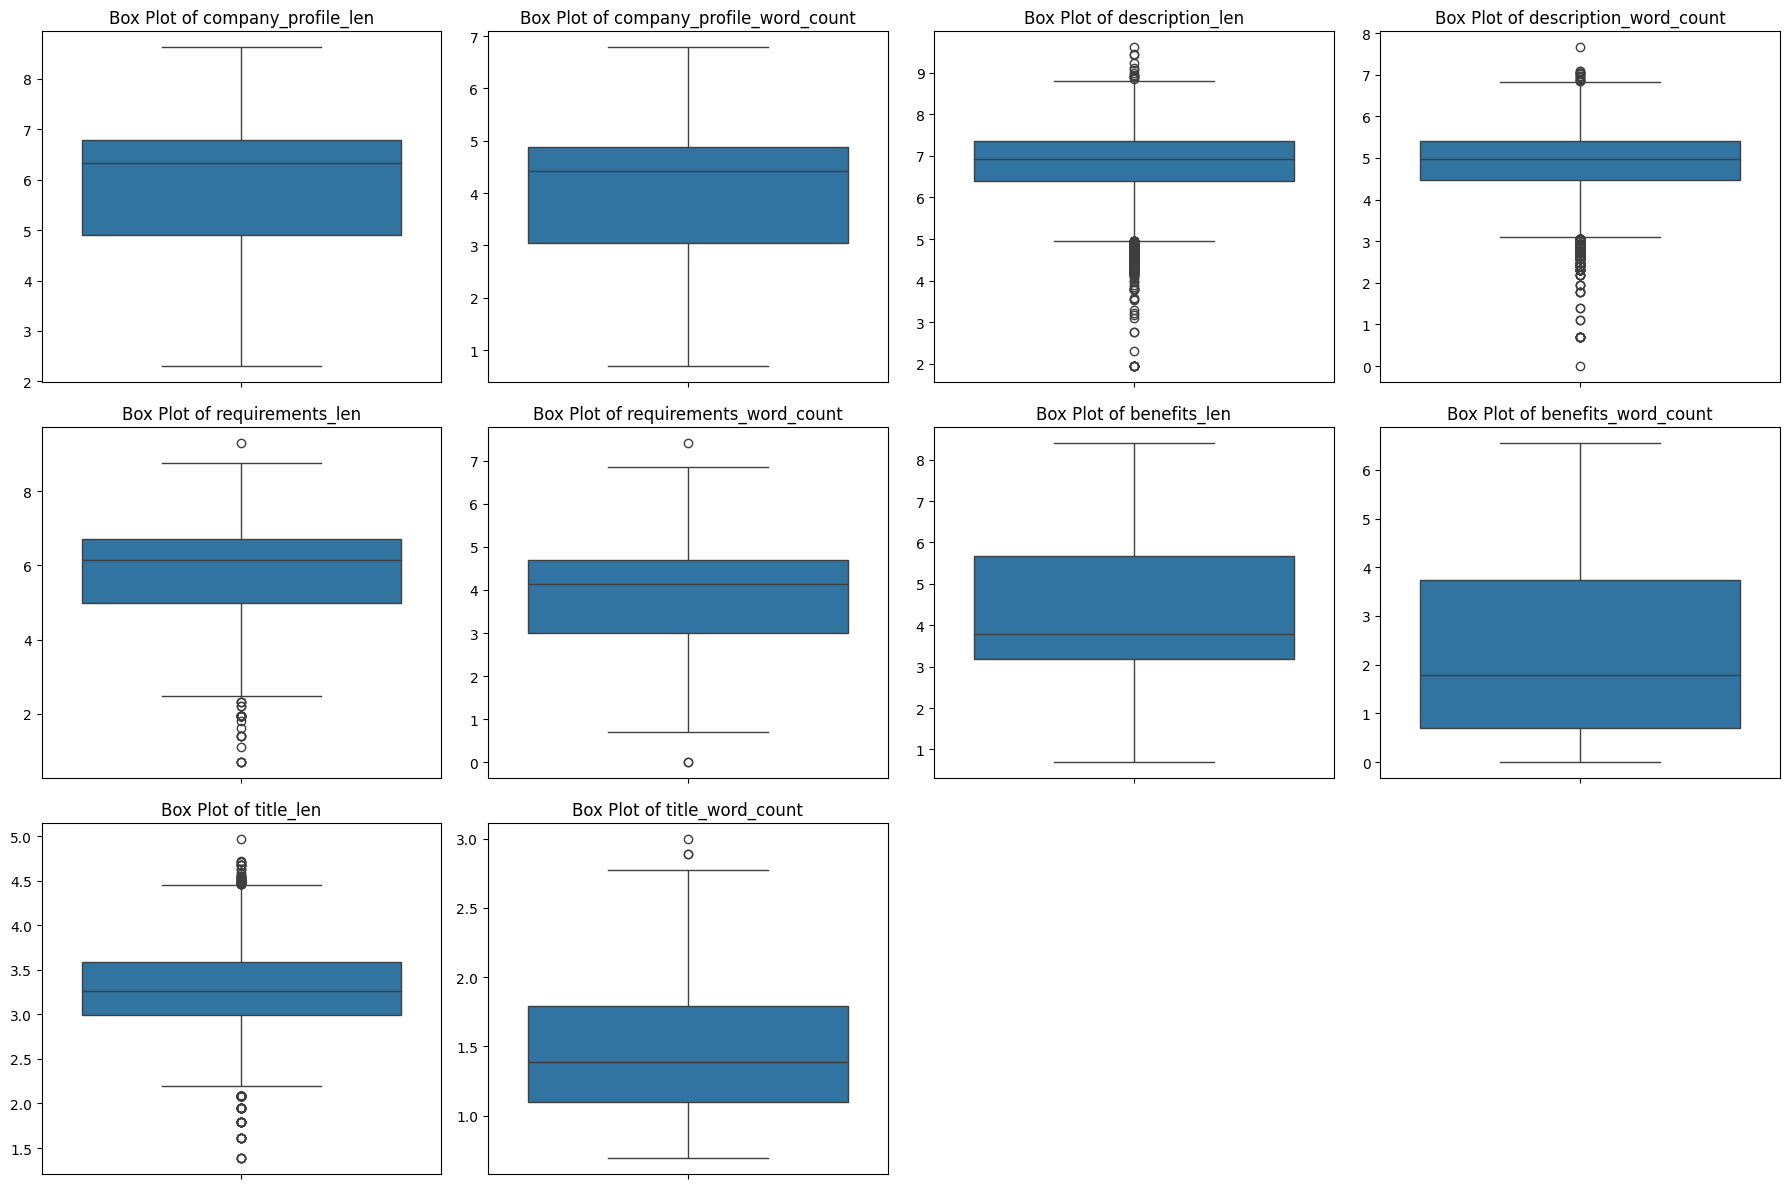

In [304]:
numerical_features = [
    'company_profile_len', 'company_profile_word_count',
    'description_len', 'description_word_count',
    'requirements_len', 'requirements_word_count',
    'benefits_len', 'benefits_word_count',
    'title_len', 'title_word_count'
]

# Plotting box plots for outlier detection
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [305]:
# Display descriptive statistics for these numerical features to quantify outliers
print("\nDescriptive Statistics for numerical features:")
df[numerical_features].describe()


Descriptive Statistics for numerical features:


,company_profile_len,company_profile_word_count,description_len,description_word_count,requirements_len,requirements_word_count,benefits_len,benefits_word_count,title_len,title_word_count
count,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000,14304.000000
mean,5.750232,3.748862,6.841893,4.879219,5.734850,3.662524,4.404301,2.263665,3.287580,1.484644
std,1.461788,1.653472,0.770762,0.776412,1.379066,1.497126,1.405130,1.592126,0.442425,0.376918
min,2.302585,0.693147,1.945910,0.000000,0.693147,0.000000,0.693147,0.000000,1.386294,0.693147
25%,4.905275,3.044522,6.403574,4.465908,4.997212,2.995732,3.178054,0.693147,2.995732,1.098612
50%,6.329721,4.430817,6.919684,4.976734,6.147399,4.143135,3.784190,1.791759,3.258097,1.386294
75%,6.779922,4.890349,7.368340,5.411646,6.712956,4.691348,5.666427,3.737670,3.583519,1.791759
max,8.626048,6.786717,9.609653,7.657283,9.293302,7.406103,8.396155,6.543912,4.962845,2.995732


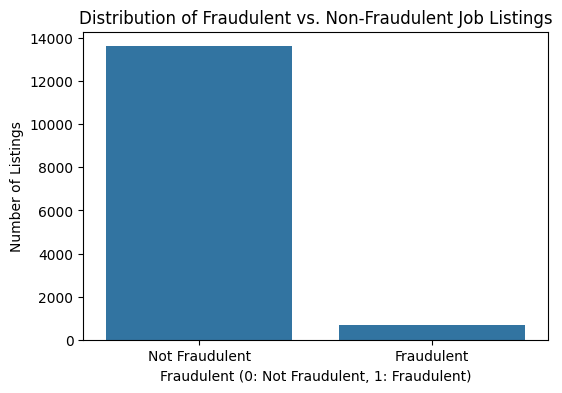


Distribution of Fraudulent vs. Non-Fraudulent Listings:
fraudulent
0    13611
1      693
Name: count, dtype: int64
Percentage of Fraudulent Listings: 4.84%


In [306]:
# Target Variable Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Job Listings')
plt.xlabel('Fraudulent (0: Not Fraudulent, 1: Fraudulent)')
plt.ylabel('Number of Listings')
plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
plt.show()

fraud_counts = df['fraudulent'].value_counts()
print("\nDistribution of Fraudulent vs. Non-Fraudulent Listings:")
print(fraud_counts)
print(f"Percentage of Fraudulent Listings: {(fraud_counts[1] / len(df) * 100):.2f}%")

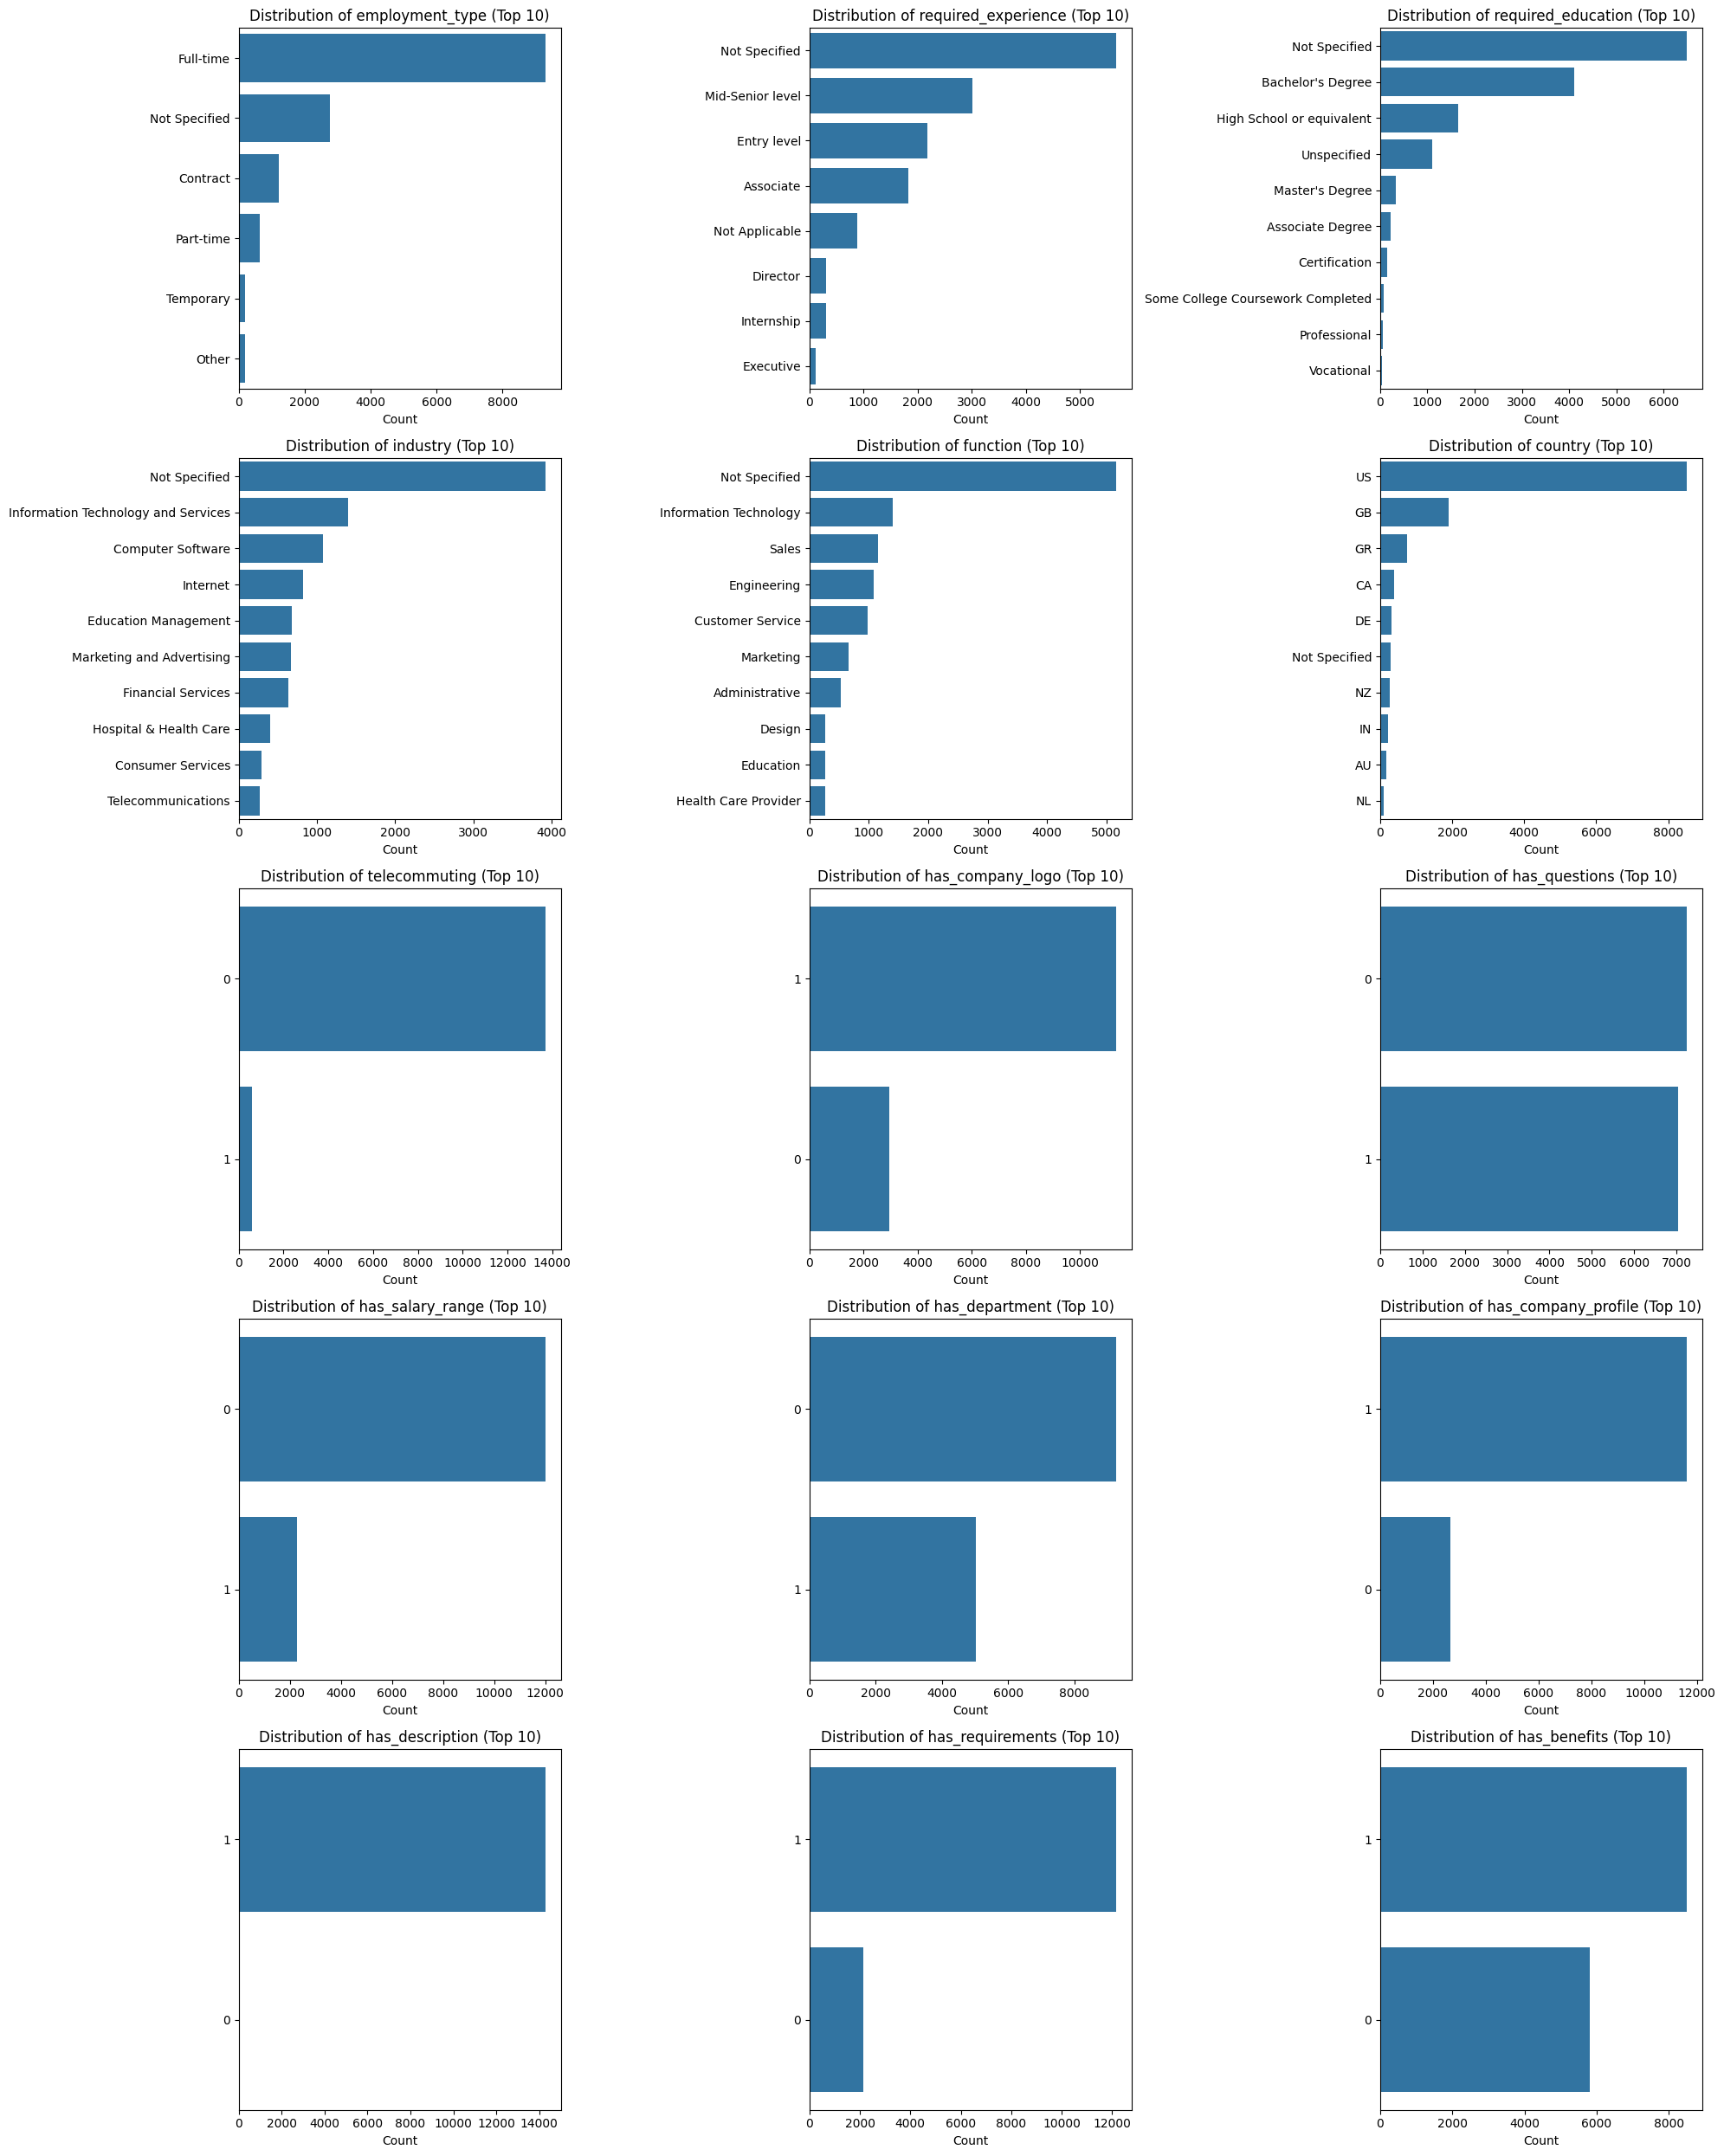

In [ ]:
# Univariate Analysis of Categorical Features

categorical_features_for_eda = [
    'employment_type', 'required_experience', 'required_education',
    'industry', 'function', 'country', 'telecommuting', 'has_company_logo',
    'has_questions', 'has_salary_range', 'has_department',
    'has_company_profile', 'has_description', 'has_requirements', 'has_benefits'
]

plt.figure(figsize=(20, 25))
for i, col in enumerate(categorical_features_for_eda):
    plt.subplot(5, 3, i + 1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'Distribution of {col} (Top 10)')
    plt.xlabel('Count')
    plt.ylabel('')
plt.tight_layout()
plt.show()

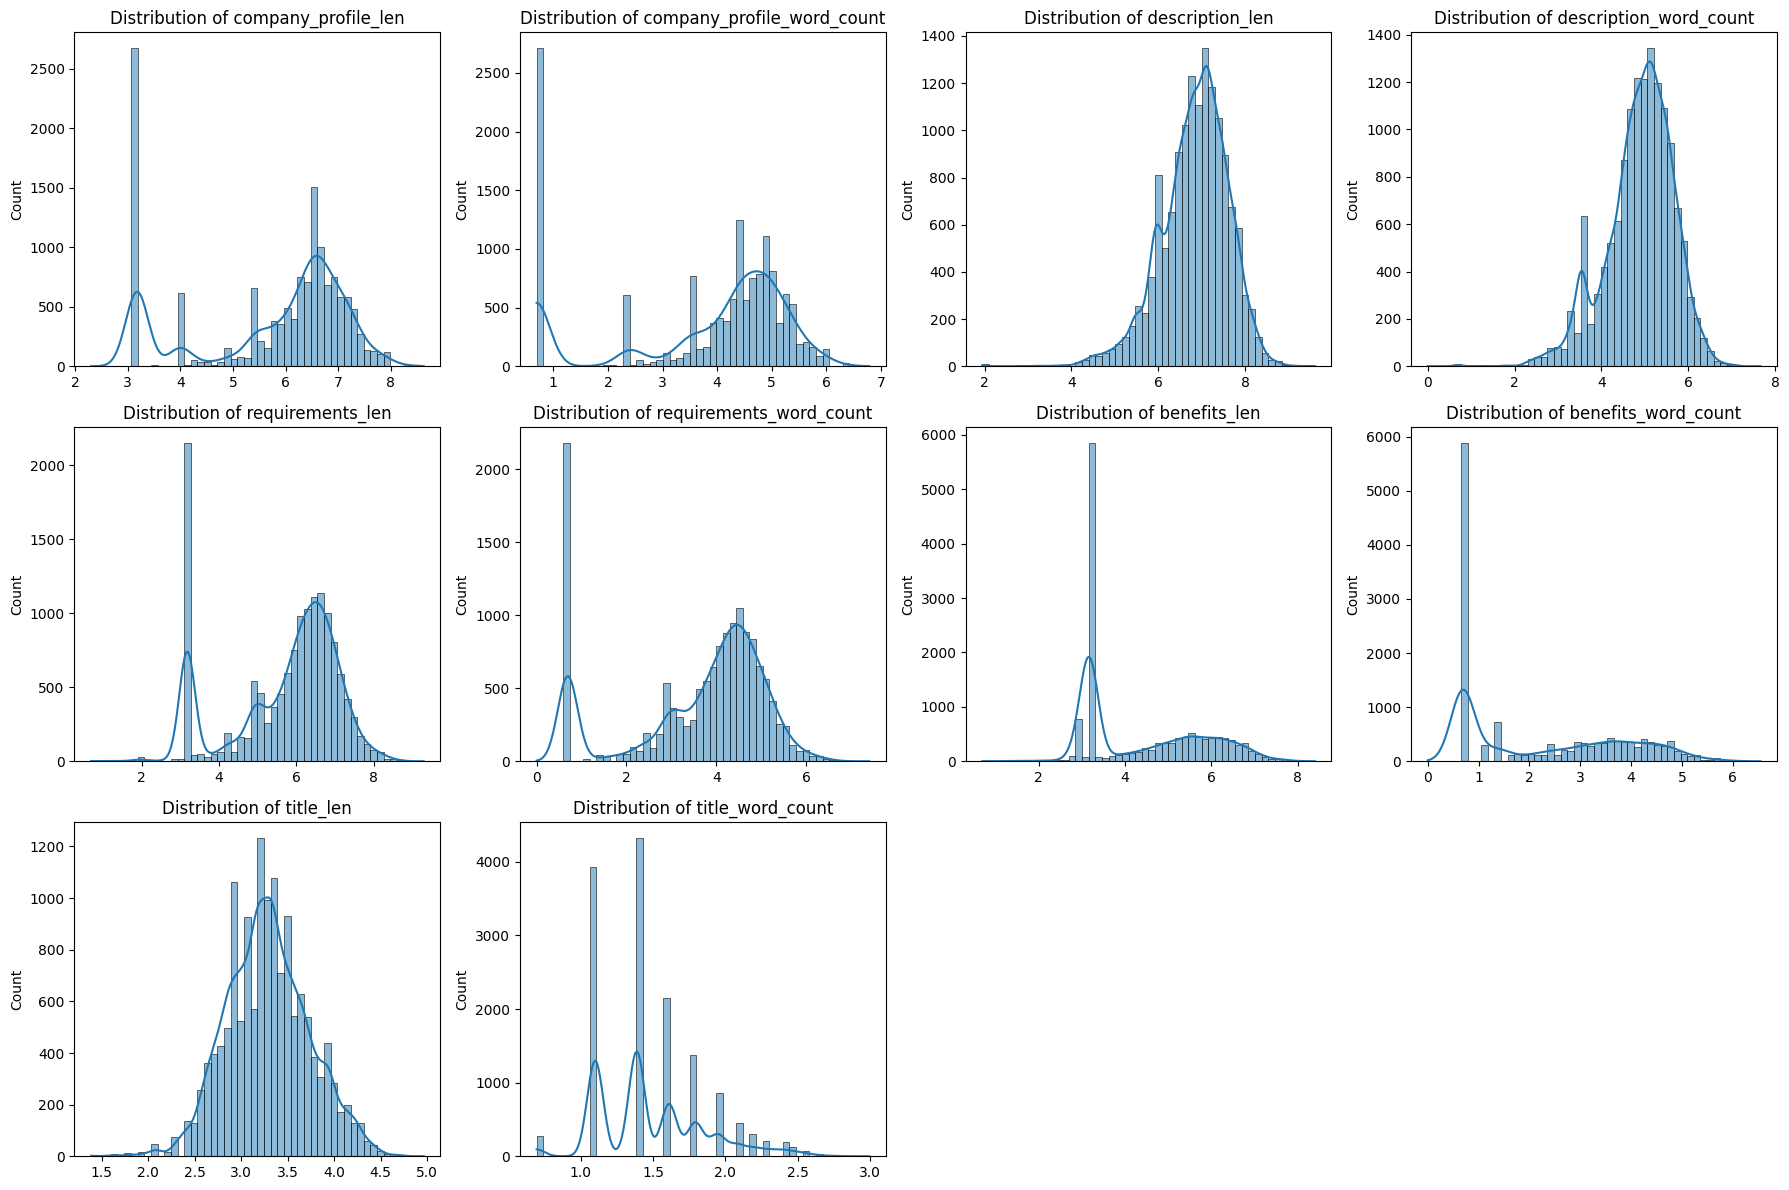

In [308]:
# Univariate Analysis of Numerical Features (Histograms)
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

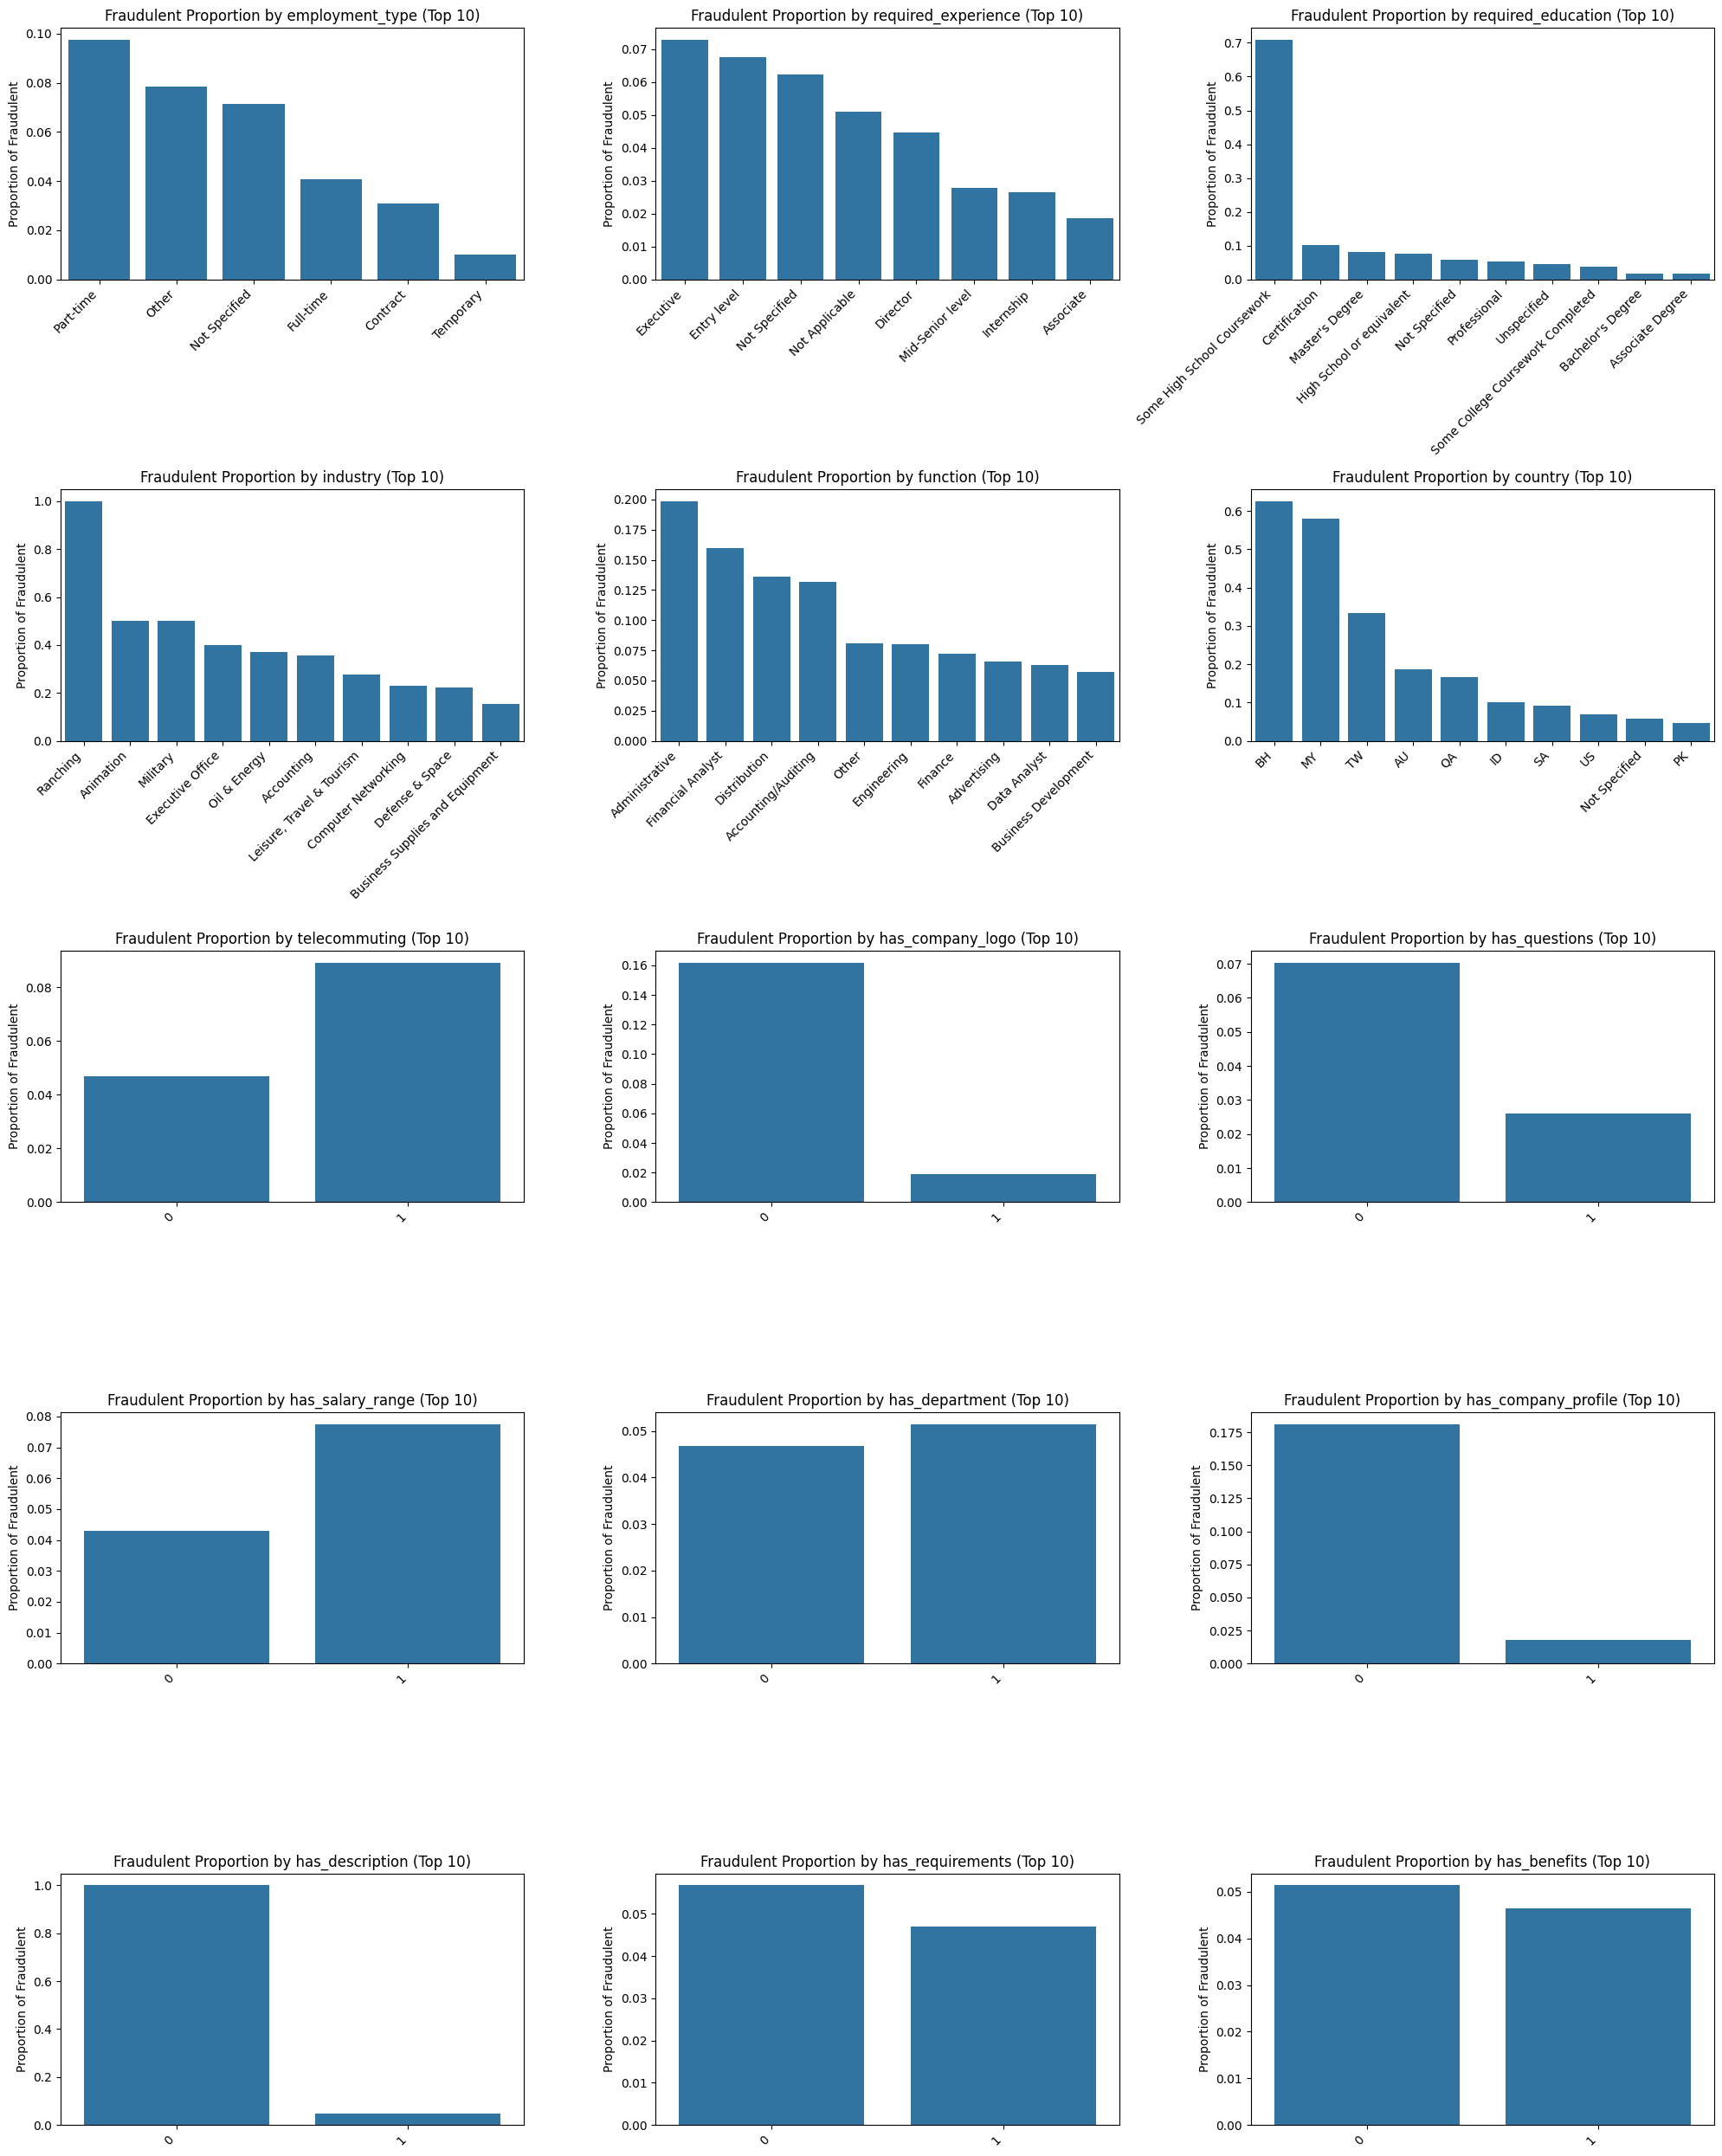

In [ ]:
# Categorical Features vs. Fraudulent
plt.figure(figsize=(20, 25))
for i, col in enumerate(categorical_features_for_eda):
    plt.subplot(5, 3, i + 1)
    # Calculate the proportion of fraudulent listings for each category
    fraud_proportions = df.groupby(col)['fraudulent'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=fraud_proportions.index, y=fraud_proportions.values)
    plt.title(f'Fraudulent Proportion by {col} (Top 10)')
    plt.xlabel('')
    plt.ylabel('Proportion of Fraudulent')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

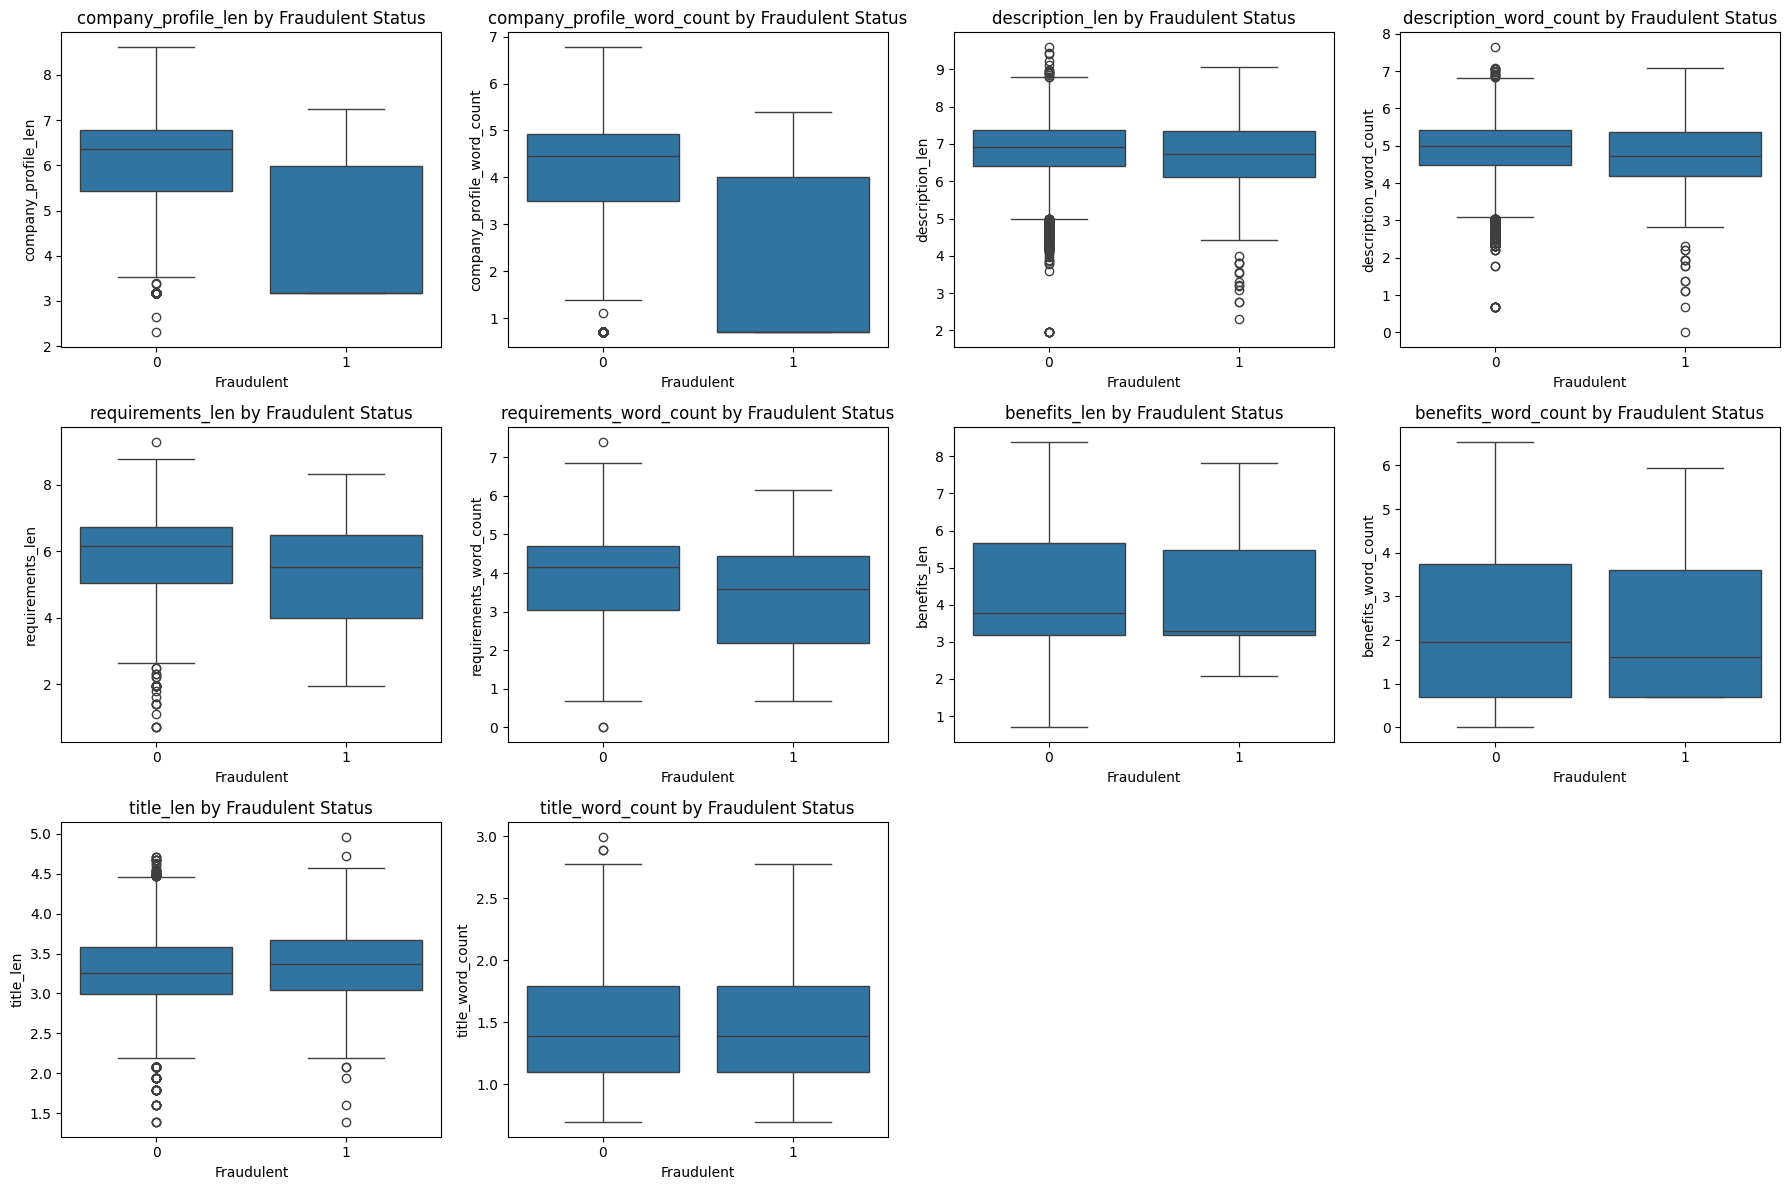

In [310]:
# Numerical Features vs. Fraudulent (Box Plots comparing distributions)
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='fraudulent', y=df[col], data=df)
    plt.title(f'{col} by Fraudulent Status')
    plt.xlabel('Fraudulent')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

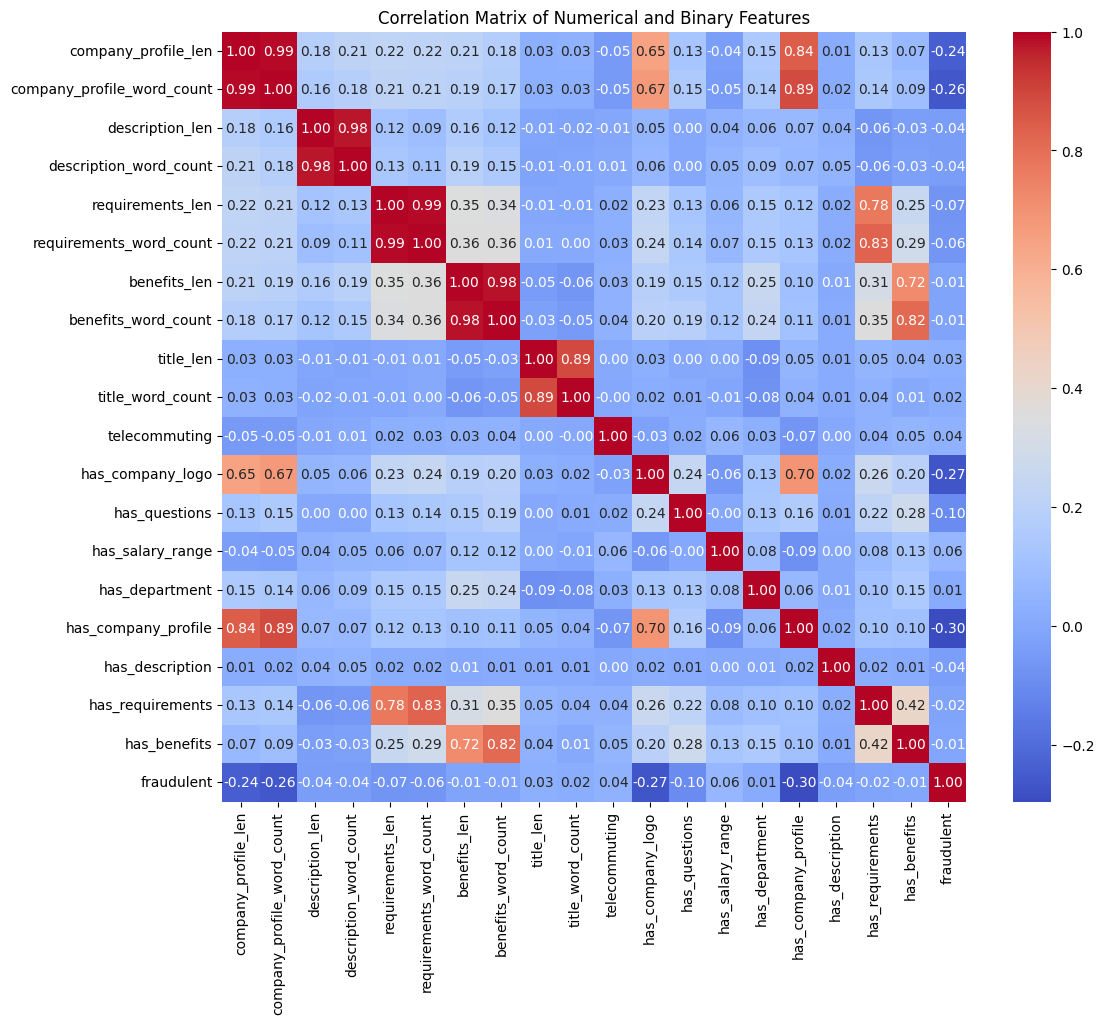

In [311]:
# Select only numerical columns for correlation matrix
numerical_and_binary_features = numerical_features + [
    'telecommuting', 'has_company_logo', 'has_questions',
    'has_salary_range', 'has_department', 'has_company_profile',
    'has_description', 'has_requirements', 'has_benefits', 'fraudulent'
]
correlation_matrix = df[numerical_and_binary_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical and Binary Features')
plt.show()

### <b>Below this All function are used to handle Data Leakage when fitting Training Data<b>

In [312]:
text_columns_for_tfidf = ['title', 'company_profile', 'description', 'requirements', 'benefits']
outlier_columns = ['description_len', 'description_word_count', 
                           'requirements_len', 'requirements_word_count',
                            'title_len', 'title_word_count']
categorical_cols_for_ohe = ['employment_type', 'required_experience', 'required_education',
                                       'industry', 'function', 'country']
outlier_bounds = {}
fitted_tfidf_vectorizers = {}
fitted_ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
fitted_scaler = MaxAbsScaler()
numerical_columns = None

In [313]:
def detect_outliers_bounds(df, columns):
    print(f"--- Detecting Outlier Bounds using 'z-score' method ---")

    for col in columns:
        if col in df.columns:
            data = df[col].values
            
            # Use Z-score method
            mean = np.mean(data)
            std = np.std(data)
            lower_bound = mean - 1.5 * std
            upper_bound = mean + 1.5 * std
            
            outlier_bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
            
            # Count outliers for reporting
            outlier_count = np.sum((data < lower_bound) | (data > upper_bound))
            print(f"  - {col}: bounds [{lower_bound:.2f}, {upper_bound:.2f}], outliers: {outlier_count}")
            
    return outlier_bounds

In [ ]:
def handle_outliers(df, fit=True):
    print("--- Handling Outliers ---")
    
    if fit:
        
        outlier_bounds_local = detect_outliers_bounds(df, outlier_columns)
    else:
        if outlier_bounds is None:
            print("Error: When fit is False, outlier_bounds must be provided.")
            return df 
        outlier_bounds_local = outlier_bounds
    
    if not outlier_bounds_local:
        print("No outlier bounds available. Skipping outlier handling.")
        return df
    df_processed = df.copy()
    total_capped = 0
    
    for col in outlier_columns:
        if col in outlier_bounds:
            bounds = outlier_bounds_local[col]
            
            below_lower = np.sum(df_processed[col] < bounds['lower'])
            above_upper = np.sum(df_processed[col] > bounds['upper'])
            
            # Cap outliers (Winsorization)
            df_processed[col] = np.clip(df_processed[col], bounds['lower'], bounds['upper'])
            
            capped_count = below_lower + above_upper
            total_capped += capped_count
            
            if capped_count > 0:
                print(f"  - {col}: capped {capped_count} outliers ({below_lower} below, {above_upper} above)")
    
    print(f"Total outliers capped: {total_capped}")
    
    return df_processed

In [315]:
def create_tfidf_features(df, fit=True):
    print("--- TF-IDF Vectorization ---")
    
    tfidf_features = []
    for col in text_columns_for_tfidf:
        if fit:
            vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
            col_tfidf = vectorizer.fit_transform(df[col])
            fitted_tfidf_vectorizers[col] = vectorizer
        else:
            if col not in fitted_tfidf_vectorizers:
                raise ValueError(f"Vectorizer for column '{col}' not fitted")
            vectorizer = fitted_tfidf_vectorizers[col]
            col_tfidf = vectorizer.transform(df[col])
        
        tfidf_features.append(col_tfidf)
        print(f"  - '{col}' TF-IDF shape: {col_tfidf.shape}")
    
    all_tfidf_features = scipy.sparse.hstack(tfidf_features)
    print(f"Combined TF-IDF features shape: {all_tfidf_features.shape}")
    
    return all_tfidf_features

In [316]:
def create_categorical_features(df, fit=True):
    print("--- One-Hot Encoding ---")
    if fit:
        encoded_features = fitted_ohe_encoder.fit_transform(df[categorical_cols_for_ohe])
    else:
        if fitted_ohe_encoder is None:
            raise ValueError("OneHotEncoder not fitted")
        encoded_features = fitted_ohe_encoder.transform(df[categorical_cols_for_ohe])
    
    print(f"  - One-Hot Encoded features shape: {encoded_features.shape}")
    
    return encoded_features

In [317]:
def create_numerical_features(df):
    print("--- Extracting Numerical/Binary Features ---")
    
    # Define columns to exclude from numerical features
    columns_to_exclude = (text_columns_for_tfidf + 
                        categorical_cols_for_ohe + 
                        ['job_id', 'location', 'fraudulent'])
    
    # Include log-transformed versions if they exist
    
    columns_to_keep = [col for col in df.columns if col not in columns_to_exclude]
    
    # Remove duplicates and ensure consistent ordering
    columns_to_keep = list(dict.fromkeys(columns_to_keep))
    
    # Store numerical columns for consistency in transform
    numerical_columns = columns_to_keep
    
    df_numerical_binary = df[numerical_columns].copy()
    numerical_binary_sparse = scipy.sparse.csr_matrix(df_numerical_binary.values)
    
    print(f"  - Numerical/Binary features shape: {numerical_binary_sparse.shape}")
    print(f"  - Numerical columns: {len(numerical_columns)}")
    
    return numerical_binary_sparse

In [318]:
def combine_features(numerical_features, tfidf_features, categorical_features):
    print("--- Combining All Features ---")
    
    X = scipy.sparse.hstack([numerical_features, tfidf_features, categorical_features])
    print(f"Final Features (X) shape: {X.shape}")
    
    return X

In [319]:
def scale_features(X, fit=True):
    if fit:
        print("--- Fitting and Scaling Features ---")
        X_scaled = fitted_scaler.fit_transform(X)
        print(f"  - Features scaled using MaxAbsScaler")
    else:
        print("--- Scaling Features (using fitted scaler) ---")
        if fitted_scaler is None:
            raise ValueError("Scaler must be fitted before transforming")
        X_scaled = fitted_scaler.transform(X)
        print(f"  - Features scaled using fitted MaxAbsScaler")

    print(f"  - Scaled features shape: {X_scaled.shape}")
    return X_scaled

In [320]:
def process_data(df, fit=True):
    df_processed = handle_outliers(df, fit=fit)
        

    tfidf_features = create_tfidf_features(df_processed, fit=fit)
    
    categorical_features = create_categorical_features(df_processed, fit=fit)
    
    numerical_features = create_numerical_features(df_processed)
    
    X = combine_features(numerical_features, tfidf_features, categorical_features)
    
    X_scaled = scale_features(X, fit=fit)
    
    return X_scaled, df_processed

In [321]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

In [322]:
print(f'Train set Shape: {df_train.shape}')
print(f'Train set Shape: {df_valid.shape}')


Train set Shape: (11443, 33)
Train set Shape: (2861, 33)


In [323]:
X_train_scaled, df_train_processed = process_data(df_train, fit=True)
y_train = df_train_processed['fraudulent']

--- Handling Outliers ---
--- Detecting Outlier Bounds using 'z-score' method ---
  - description_len: bounds [5.69, 7.99], outliers: 1309
  - description_word_count: bounds [3.71, 6.04], outliers: 1619
  - requirements_len: bounds [3.66, 7.79], outliers: 2071
  - requirements_word_count: bounds [1.40, 5.90], outliers: 1958
  - title_len: bounds [2.63, 3.95], outliers: 1384
  - title_word_count: bounds [0.92, 2.05], outliers: 1322
  - description_len: capped 1309 outliers (808 below, 501 above)
  - description_word_count: capped 1619 outliers (1156 below, 463 above)
  - requirements_len: capped 2071 outliers (1869 below, 202 above)
  - requirements_word_count: capped 1958 outliers (1813 below, 145 above)
  - title_len: capped 1384 outliers (556 below, 828 above)
  - title_word_count: capped 1322 outliers (221 below, 1101 above)
Total outliers capped: 9663
--- TF-IDF Vectorization ---
  - 'title' TF-IDF shape: (11443, 200)
  - 'company_profile' TF-IDF shape: (11443, 200)
  - 'descriptio

In [324]:
X_valid_scaled, df_valid_processed = process_data(df_valid, fit=False)
y_valid = df_valid_processed['fraudulent']

--- Handling Outliers ---
  - description_len: capped 322 outliers (194 below, 128 above)
  - description_word_count: capped 392 outliers (275 below, 117 above)
  - requirements_len: capped 507 outliers (448 below, 59 above)
  - requirements_word_count: capped 472 outliers (428 below, 44 above)
  - title_len: capped 369 outliers (148 below, 221 above)
  - title_word_count: capped 344 outliers (60 below, 284 above)
Total outliers capped: 2406
--- TF-IDF Vectorization ---
  - 'title' TF-IDF shape: (2861, 200)
  - 'company_profile' TF-IDF shape: (2861, 200)
  - 'description' TF-IDF shape: (2861, 200)
  - 'requirements' TF-IDF shape: (2861, 200)
  - 'benefits' TF-IDF shape: (2861, 200)
Combined TF-IDF features shape: (2861, 1000)
--- One-Hot Encoding ---
  - One-Hot Encoded features shape: (2861, 280)
--- Extracting Numerical/Binary Features ---
  - Numerical/Binary features shape: (2861, 19)
  - Numerical columns: 19
--- Combining All Features ---
Final Features (X) shape: (2861, 1299)
--

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {
    'logistic_regression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        C= 1,
        penalty= "l2",
        class_weight='balanced',
        fit_intercept=False,
        solver='liblinear',
    ),
    'svm': SVC(
        random_state=42,
        probability=True,
        class_weight='balanced',
        C=1.0,
        gamma=0.1,
        kernel='rbf',

    ),
    'ada_boost': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            random_state=42, 
            criterion='log_loss',
            max_depth=5,
            ),
        n_estimators=300,
        learning_rate=0.1,
        random_state=42,
    ),
    'random_forest': RandomForestClassifier(
        random_state=42,
        bootstrap=True,
        oob_score=True,
        max_samples=0.8,
        class_weight="balanced",
        max_features=None,
        max_depth=None,
        criterion='log_loss',
        min_samples_leaf=1,
        min_samples_split= 3,
        n_estimators=200,
    ),
    'gradient_boosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=300,
        learning_rate=0.1,
        max_depth=10,
        validation_fraction=0.1,
        n_iter_no_change=10,
        tol=1e-4, 
        subsample=0.8,
        max_features=None,
        loss='log_loss',
        min_samples_leaf=6,
        min_samples_split=5,
    ),
}

In [286]:
models_to_train = ['logistic_regression', 'svm', 'ada_boost', 'gradient_boosting', 'random_forest']

trained_models = {}
for model_name in models_to_train:
    if model_name not in models:
        print(f"Warning: Model '{model_name}' not found. Skipping...")
        continue

    print(f"\n{'='*40}")
    print(f"Training: {model_name.upper()}")
    print(f"{'='*40}")

    try:
        # Get model and parameter grid
        model = models[model_name]

        cv_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # Fit the model
        model.fit(X_train_scaled, y_train)
        
        print("Model_trained")
        # Store results
        trained_models[model_name] = model
            
    except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
        continue


Training: LOGISTIC_REGRESSION
Model_trained

Training: SVM
Model_trained

Training: ADA_BOOST
Model_trained

Training: GRADIENT_BOOSTING
Model_trained

Training: RANDOM_FOREST
Model_trained



Evaluating: LOGISTIC_REGRESSION
Metric Scores for LOGISTIC_REGRESSION
  Accuracy: 0.9595
  Precision: 0.5275
  Recall: 0.8984
  F1-Score: 0.6647

DETAILED REPORT FOR LOGISTIC_REGRESSION

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2733
           1       0.53      0.90      0.66       128

    accuracy                           0.96      2861
   macro avg       0.76      0.93      0.82      2861
weighted avg       0.97      0.96      0.96      2861


Confusion Matrix:


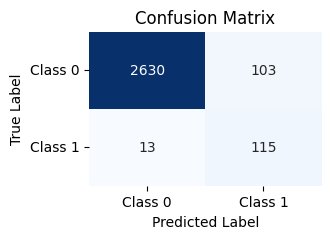


Evaluating: SVM
Metric Scores for SVM
  Accuracy: 0.9867
  Precision: 0.8750
  Recall: 0.8203
  F1-Score: 0.8468

DETAILED REPORT FOR SVM

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2733
           1       0.88      0.82      0.85       128

    accuracy                           0.99      2861
   macro avg       0.93      0.91      0.92      2861
weighted avg       0.99      0.99      0.99      2861


Confusion Matrix:


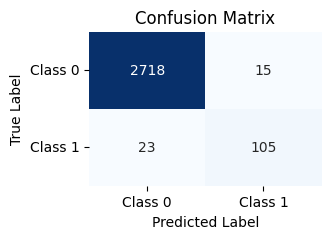


Evaluating: ADA_BOOST
Metric Scores for ADA_BOOST
  Accuracy: 0.9762
  Precision: 0.9167
  Recall: 0.5156
  F1-Score: 0.6600

DETAILED REPORT FOR ADA_BOOST

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2733
           1       0.92      0.52      0.66       128

    accuracy                           0.98      2861
   macro avg       0.95      0.76      0.82      2861
weighted avg       0.98      0.98      0.97      2861


Confusion Matrix:


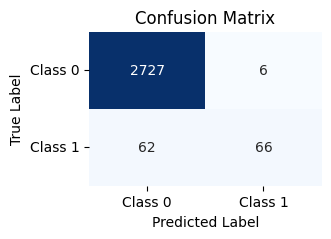


Evaluating: GRADIENT_BOOSTING
Metric Scores for GRADIENT_BOOSTING
  Accuracy: 0.9832
  Precision: 0.9348
  Recall: 0.6719
  F1-Score: 0.7818

DETAILED REPORT FOR GRADIENT_BOOSTING

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2733
           1       0.93      0.67      0.78       128

    accuracy                           0.98      2861
   macro avg       0.96      0.83      0.89      2861
weighted avg       0.98      0.98      0.98      2861


Confusion Matrix:


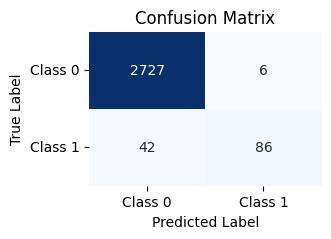


Evaluating: RANDOM_FOREST
Metric Scores for RANDOM_FOREST
  Accuracy: 0.9808
  Precision: 0.9011
  Recall: 0.6406
  F1-Score: 0.7489

DETAILED REPORT FOR RANDOM_FOREST

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2733
           1       0.90      0.64      0.75       128

    accuracy                           0.98      2861
   macro avg       0.94      0.82      0.87      2861
weighted avg       0.98      0.98      0.98      2861


Confusion Matrix:


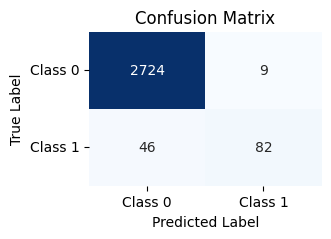

In [290]:
for model_name in models_to_train:
    model = trained_models[model_name]
    
    print(f"\n{'='*40}")
    print(f"Evaluating: {model_name.upper()}")
    print(f"{'='*40}")

    y_pred = model.predict(X_valid_scaled)
    metrics = {
        'accuracy': accuracy_score(y_valid, y_pred),
        'precision': precision_score(y_valid, y_pred),
        'recall': recall_score(y_valid, y_pred),
        'f1_score': f1_score(y_valid, y_pred),
    }
    print(f"Metric Scores for {model_name.upper()}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"\nDETAILED REPORT FOR {model_name.upper()}")
    print("="*50)
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred))
    print("\nConfusion Matrix:")

    cm = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(3, 2))
    sns.heatmap(
        cm,
        annot=True, 
        fmt='d',    
        cmap='Blues',  
        cbar=False
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1']) # Custom x-axis labels
    plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'], rotation=0) # Custom y-axis labels
    plt.show()    

In [291]:
for model_name in models_to_train:
    model = models[model_name]

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print(f"\n{'-'*40}")
    print(f"Performing cross-validation on {model_name.upper()} for F1 score...")
    print("-"*40)
    f1_scores = cross_val_score(
        model,     
        X_train_scaled,      
        y_train,     
        cv=cv, 
        scoring='f1'  
    )

    print(f"F1 Scores for each fold: {f1_scores}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} +- {np.std(f1_scores):.4f}")


----------------------------------------
Performing cross-validation on LOGISTIC_REGRESSION for F1 score...
----------------------------------------
F1 Scores for each fold: [0.70533643 0.69105691 0.67755102]
Mean F1 Score: 0.6913 +- 0.0113

----------------------------------------
Performing cross-validation on SVM for F1 score...
----------------------------------------
F1 Scores for each fold: [0.83086053 0.83667622 0.84269663]
Mean F1 Score: 0.8367 +- 0.0048

----------------------------------------
Performing cross-validation on ADA_BOOST for F1 score...
----------------------------------------
F1 Scores for each fold: [0.66435986 0.6440678  0.6894198 ]
Mean F1 Score: 0.6659 +- 0.0185

----------------------------------------
Performing cross-validation on GRADIENT_BOOSTING for F1 score...
----------------------------------------
F1 Scores for each fold: [0.73615635 0.78338279 0.76100629]
Mean F1 Score: 0.7602 +- 0.0193

----------------------------------------
Performing cross-v